In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore
from disp import set_plot, plot_b

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_MDLS = ['lin', 'ln', 'dyn']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_mdl in NRL_MDLS
]

In [2]:
DF_LIN_PARAM = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
DF_LN_PARAM = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_SMOOTH = 15

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

EXPT_IDS = DF_LIN_PARAM['EXPT_ID']

In [3]:
# linear simulation
# filters (downsampled)
hs_lin_dn_s = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_lin_dn_p = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_lin_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_s])[:-1]) for h_lin_dn_s in hs_lin_dn_s])
hs_lin_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_p])[:-1]) for h_lin_dn_p in hs_lin_dn_p])

hs_lin_s = np.array([smooth(h_lin_s, H_SMOOTH) for h_lin_s in hs_lin_s])
hs_lin_p = np.array([smooth(h_lin_p, H_SMOOTH) for h_lin_p in hs_lin_p])

def smlt_lin_(i_s, i_p, h_s, h_p):
    """Single neuron"""
    r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
        + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    return r


def smlt_lin(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p) in enumerate(zip(hs_lin_s, hs_lin_p)):
        rs[:, cr] = smlt_lin_(i_s, i_p, h_s, h_p)
        
    return rs


# linear-nonlinear simulation
# filters (downsampled)
hs_ln_dn_s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_ln_dn_p = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_ln_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_s])[:-1]) for h_ln_dn_s in hs_ln_dn_s])
hs_ln_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_p])[:-1]) for h_ln_dn_p in hs_ln_dn_p])

hs_ln_s = np.array([smooth(h_ln_s, H_SMOOTH) for h_ln_s in hs_ln_s])
hs_ln_p = np.array([smooth(h_ln_p, H_SMOOTH) for h_ln_p in hs_ln_p])

r_mins = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MIN'] for expt_id in EXPT_IDS])
r_maxs = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MAX'] for expt_id in EXPT_IDS])
z_0s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['Z_0'] for expt_id in EXPT_IDS])
betas = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['BETA'] for expt_id in EXPT_IDS])

def smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Single neuron."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


def smlt_ln(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p, r_min, r_max, z_0, beta) in enumerate(zip(hs_ln_s, hs_ln_p, r_mins, r_maxs, z_0s, betas)):
        rs[:, cr] = smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        
    return rs


# nonlinear adaptive simulation
tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_ss = np.array(DF_DYN_PARAM['X_S'])
x_ps = np.array(DF_DYN_PARAM['X_P'])

def smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    tau_a = np.inf
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

def smlt_dyn(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs, tau_as, x_ss, x_ps)):
        rs[:, cr] = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
    return rs

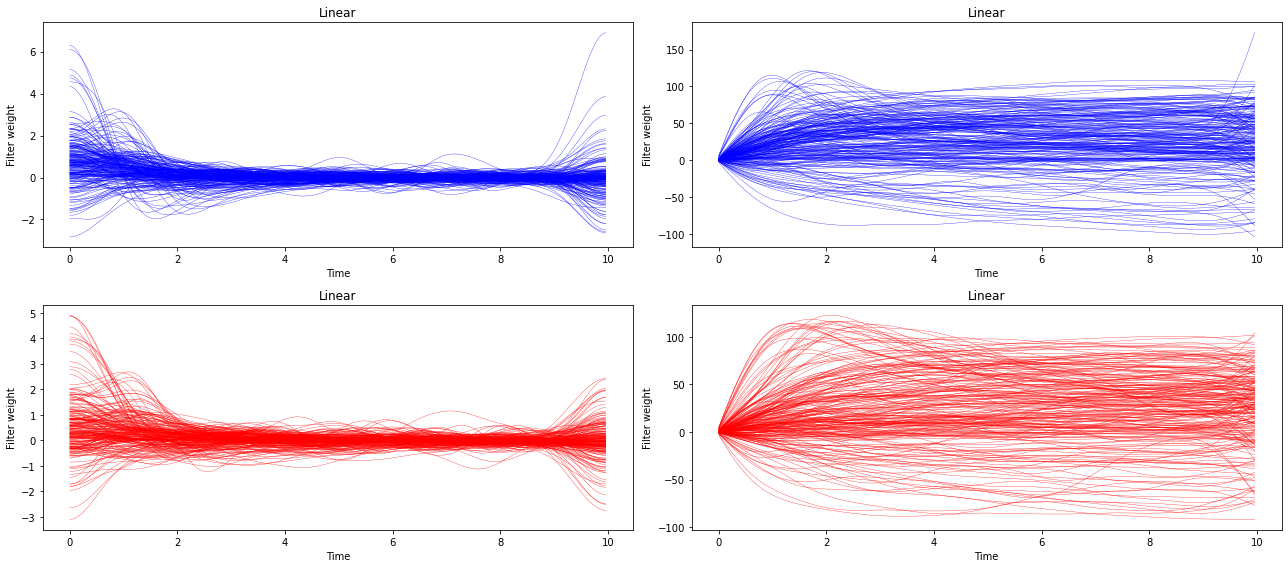

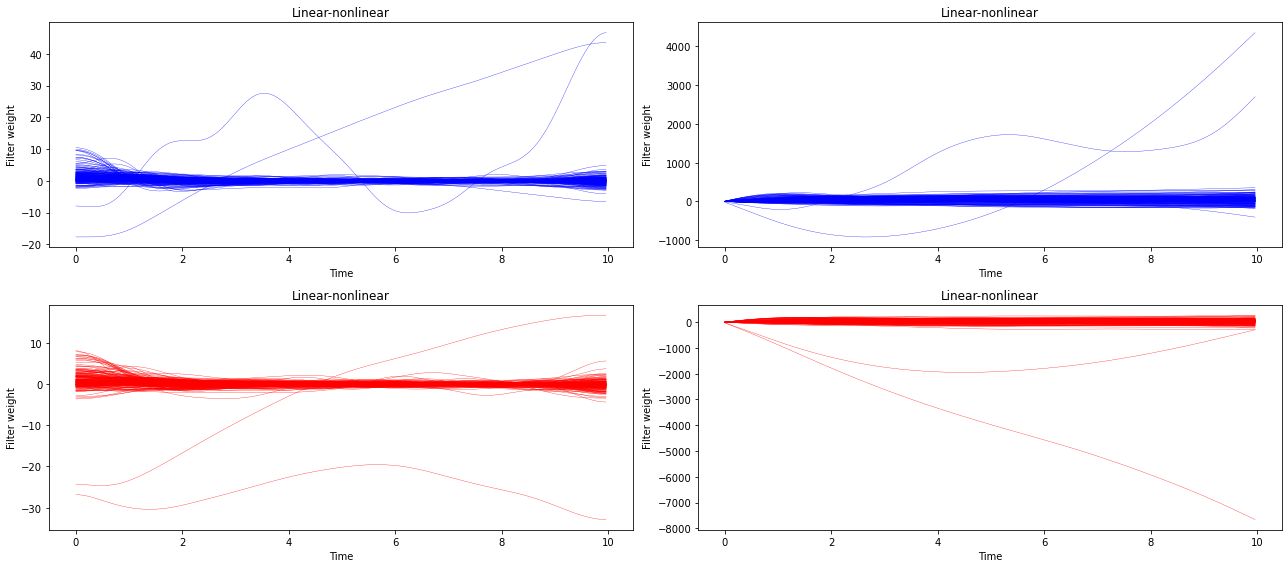

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8), tight_layout=True)
axs[0, 0].plot(T_H, hs_lin_s.T, c='b', lw=.3)
axs[0, 1].plot(T_H, hs_lin_s.T.cumsum(axis=0), c='b', lw=.3);
axs[1, 0].plot(T_H, hs_lin_p.T, c='r', lw=.3)
axs[1, 1].plot(T_H, hs_lin_p.T.cumsum(axis=0), c='r', lw=.3)
for ax in axs.flatten():
    ax.set_xlabel('Time')
    ax.set_ylabel('Filter weight')
    ax.set_title('Linear')
    
fig, axs = plt.subplots(2, 2, figsize=(18, 8), tight_layout=True)
axs[0, 0].plot(T_H, hs_ln_s.T, c='b', lw=.3)
axs[0, 1].plot(T_H, hs_ln_s.T.cumsum(axis=0), c='b', lw=.3);
axs[1, 0].plot(T_H, hs_ln_p.T, c='r', lw=.3)
axs[1, 1].plot(T_H, hs_ln_p.T.cumsum(axis=0), c='r', lw=.3);
for ax in axs.flatten():
    ax.set_xlabel('Time')
    ax.set_ylabel('Filter weight')
    ax.set_title('Linear-nonlinear')

In [5]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [6]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [7]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [8]:
from aux import get_seg
# get snippets

nt = int(round(30*FPS))
min_gap = int(round(5*FPS))
min_frac_sing = 0

sngs = []  # song snippets

for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs.extend(segs)
    
sngs = np.array(sngs)

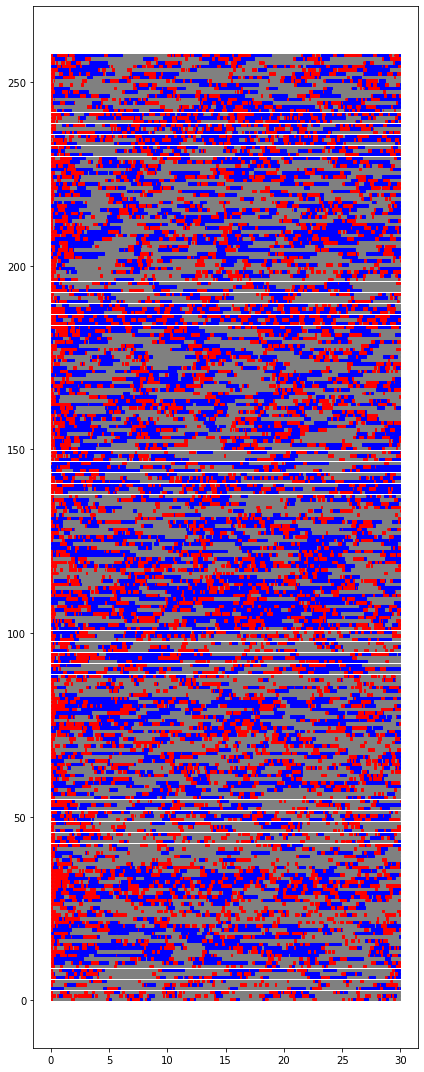

In [9]:
t = np.arange(nt)*DT
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

In [10]:
# compute responses of different neural models
import sys
nsng = len(sngs)
rsps = {nrl_mdl: np.nan*np.zeros((nsng, 224)) for nrl_mdl in NRL_MDLS}

for csng, sng in enumerate(sngs):
    sys.stdout.write('.')
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    
    # save final timepoints
    rsps['lin'][csng, :] = r_lin[-1, :]
    rsps['ln'][csng, :] = r_ln[-1, :]
    rsps['dyn'][csng, :] = r_dyn[-1, :]

..................................................................................................................................................................................................................................................................

In [11]:
# compute neural distances
ds_nrl = {nrl_mdl: np.nan * np.eye(nsng) for nrl_mdl in NRL_MDLS}

for nrl_mdl in NRL_MDLS:
    for i in range(nsng):
        for j in range(i+1, nsng):
            d_nrl = np.sqrt(np.mean((rsps[nrl_mdl][i, :] - rsps[nrl_mdl][j, :])**2))
            ds_nrl[nrl_mdl][i, j] = d_nrl

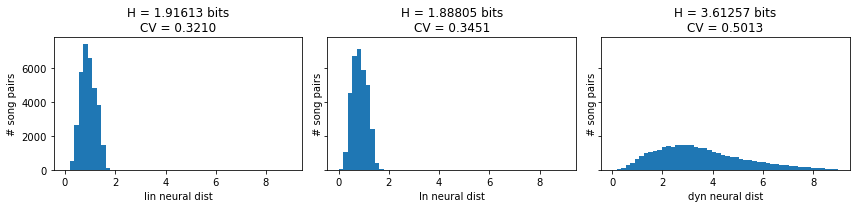

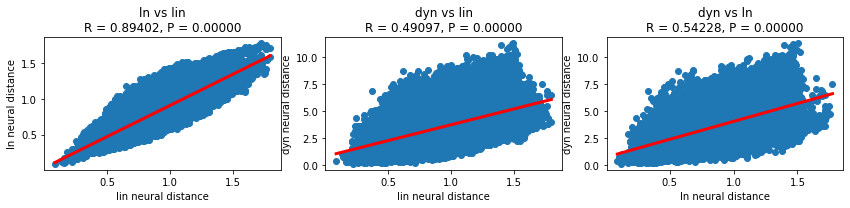

In [18]:
from scipy import stats
from disp import get_line

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True, sharey=True)
bins = np.linspace(0, 9, 51)
for nrl_mdl, ax in zip(NRL_MDLS, axs):
    cts = np.histogram(ds_nrl[nrl_mdl].flatten(), bins=bins, density=True)[0]
    cts /= cts.sum()
    
    ax.hist(ds_nrl[nrl_mdl].flatten(), bins=bins)
    ax.set_xlabel(f'{nrl_mdl} neural dist')
    ax.set_ylabel('# song pairs')
    ax.set_title(f'H = {stats.entropy(cts):.5f} bits\nCV = {np.nanstd(ds_nrl[nrl_mdl])/ np.nanmean(ds_nrl[nrl_mdl]):.4f}')
    
    
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
for (nrl_mdl_a, nrl_mdl_b), ax in zip([('lin', 'ln'), ('lin', 'dyn'), ('ln', 'dyn')], axs):
    ax.scatter(ds_nrl[nrl_mdl_a].flatten(), ds_nrl[nrl_mdl_b].flatten())
    
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl[nrl_mdl_a].flatten(), ds_nrl[nrl_mdl_b].flatten())
    
    ax.plot(x_ln, y_ln, c='r', lw=3)
    ax.set_xlabel(f'{nrl_mdl_a} neural distance')
    ax.set_ylabel(f'{nrl_mdl_b} neural distance')
    ax.set_title(f'{nrl_mdl_b} vs {nrl_mdl_a}\nR = {r:.5f}, P = {p:.5f}')

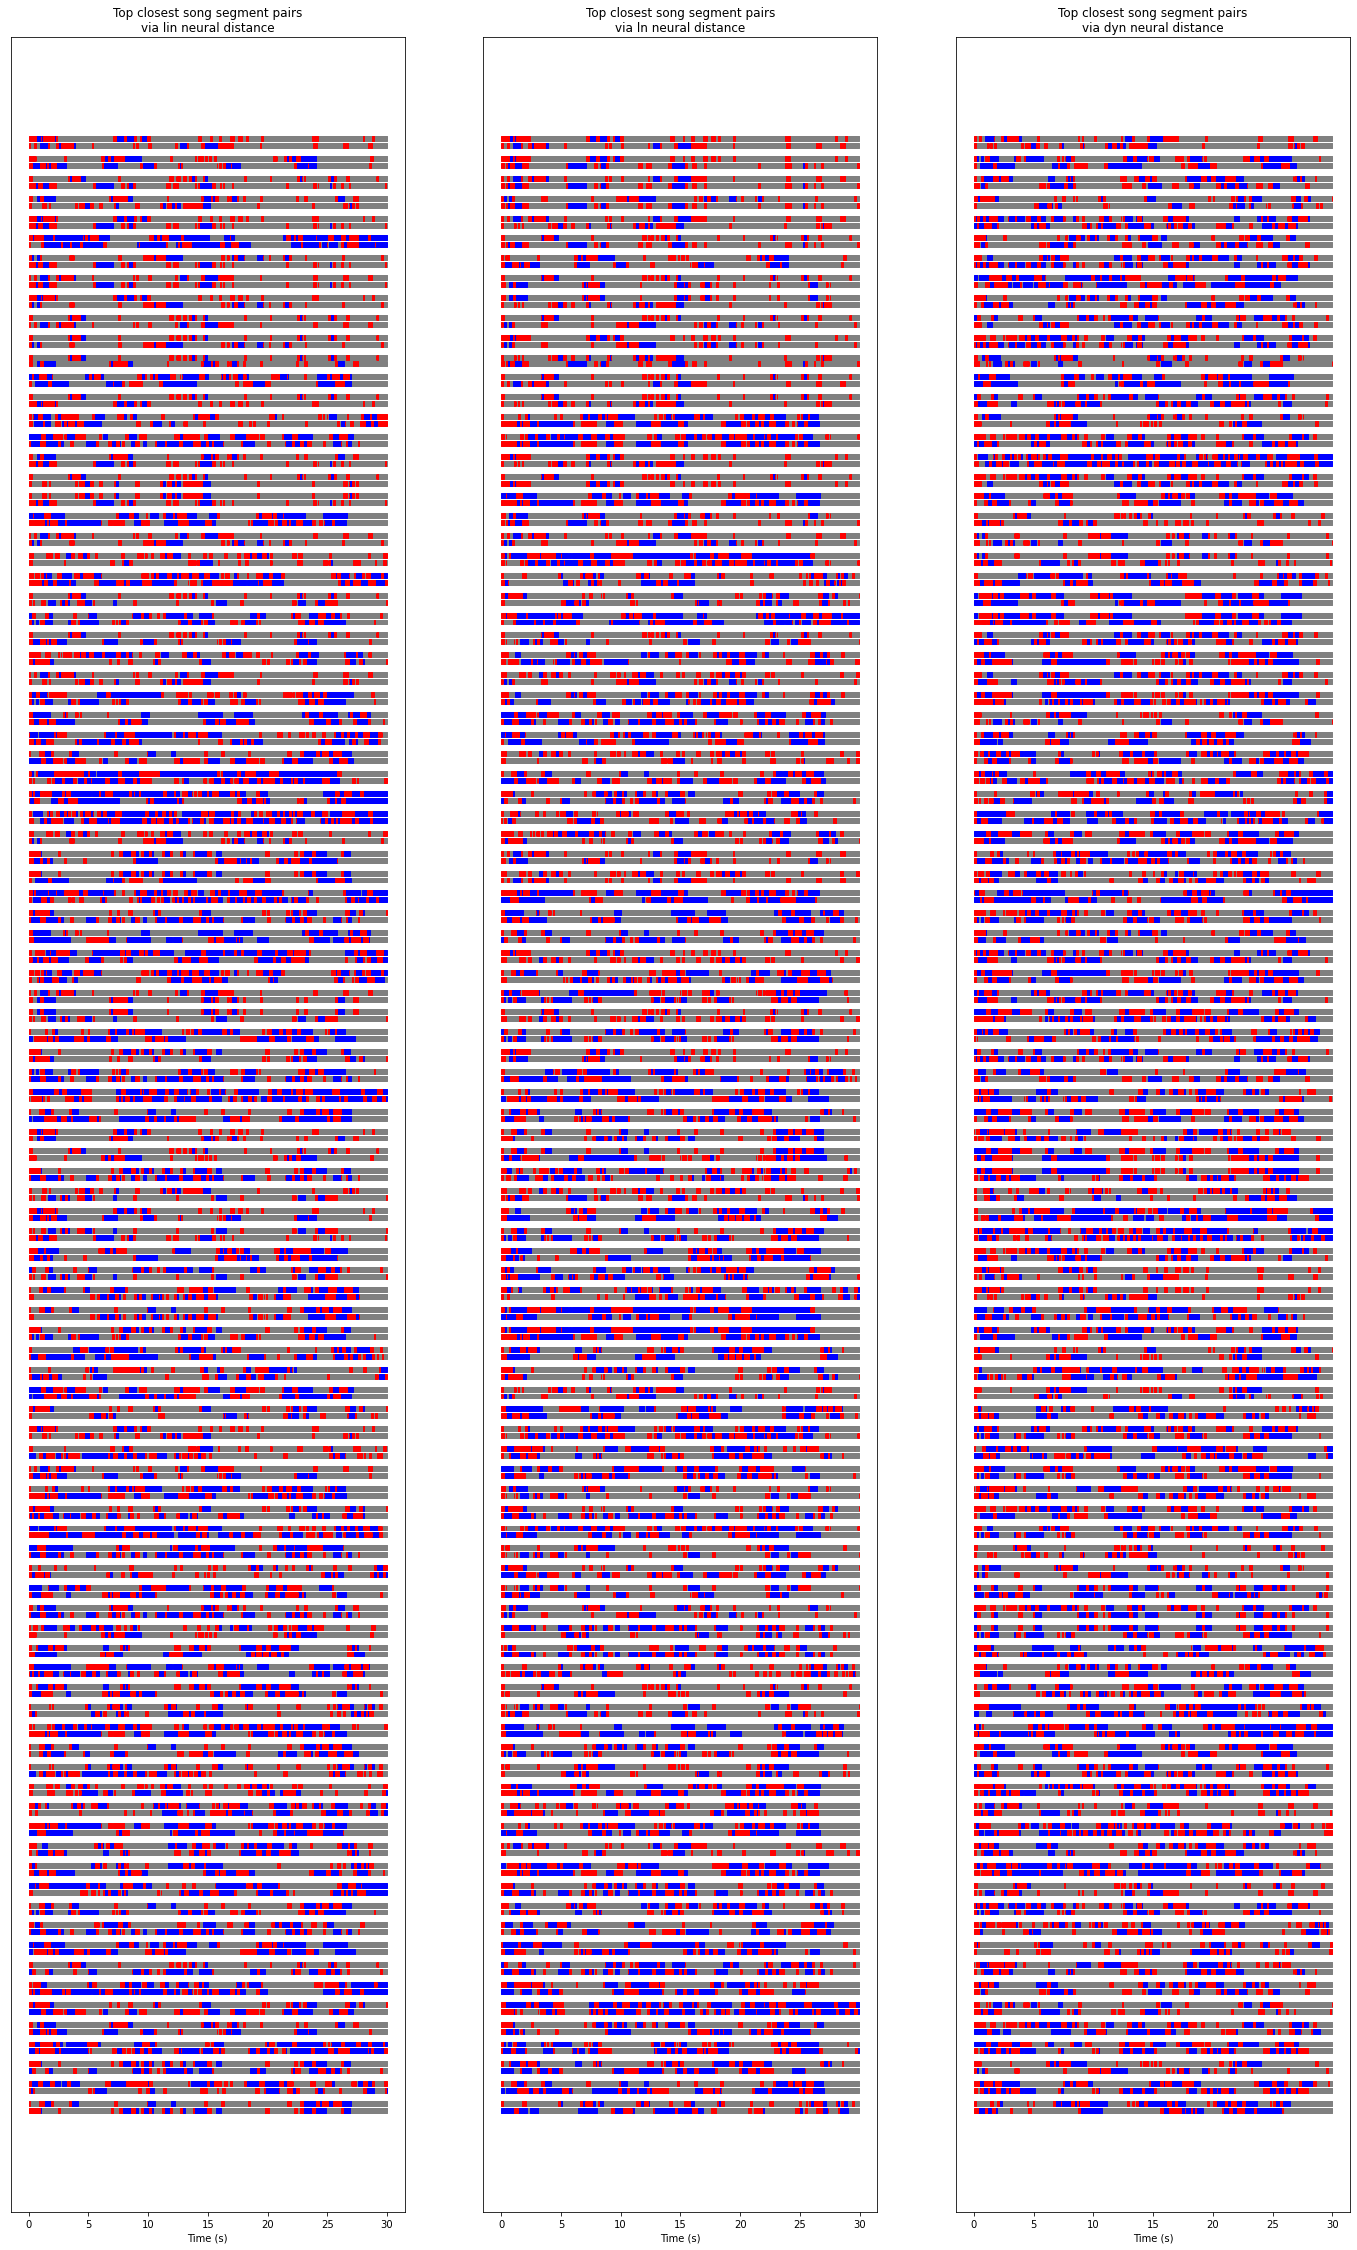

In [13]:
npair_plot = 100
fig, axs = plt.subplots(1, 3, figsize=(24, .4*npair_plot))

for nrl_mdl, ax in zip(NRL_MDLS, axs):
    ds_nrl_flat = ds_nrl[nrl_mdl].flatten()

    idxs_sorted_flat = np.argsort(ds_nrl_flat)
    idxs_sorted = np.transpose(np.unravel_index(idxs_sorted_flat, ds_nrl[nrl_mdl].shape))
    
    for cpair, (idx_a, idx_b) in enumerate(idxs_sorted[:npair_plot]):
        plot_b(ax, t, sngs[idx_a], [0, t.max(), -2*cpair, -2*cpair - .5], c=['gray', 'b', 'r'])
        plot_b(ax, t, sngs[idx_b], [0, t.max(), -2*cpair - .7, -2*cpair - 1.2], c=['gray', 'b', 'r'])
        
    ax.set_yticks([])
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Top closest song segment pairs\nvia {nrl_mdl} neural distance')
    
fig.savefig('cosyne_2022/close_songs.svg')

100 songs
100 songs
100 songs


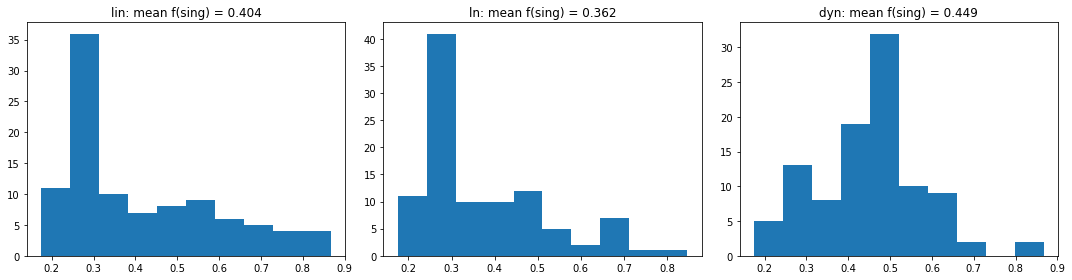

In [14]:
nsng = 100
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for nrl_mdl, ax in zip(NRL_MDLS, axs):
    ds_nrl_flat = ds_nrl[nrl_mdl].flatten()

    idxs_sorted_flat = np.argsort(ds_nrl_flat)
    
    idxs_sorted = np.transpose(np.unravel_index(idxs_sorted_flat, ds_nrl[nrl_mdl].shape))
    
    sng_idxs = idxs_sorted[:5*nsng, :].flatten()[:nsng]
    print(len(sng_idxs), 'songs')
    
    frac_sing = [np.mean(sngs[idx] > 0) for idx in sng_idxs]
    
    ax.hist(frac_sing)
    ax.set_title(f'{nrl_mdl}: mean f(sing) = {np.mean(frac_sing):.3f}')

In [15]:
def get_d_hm(x, y):
    return np.sum(x != y)

def get_d_lv(x, y):
    return editdistance.eval(x, y)

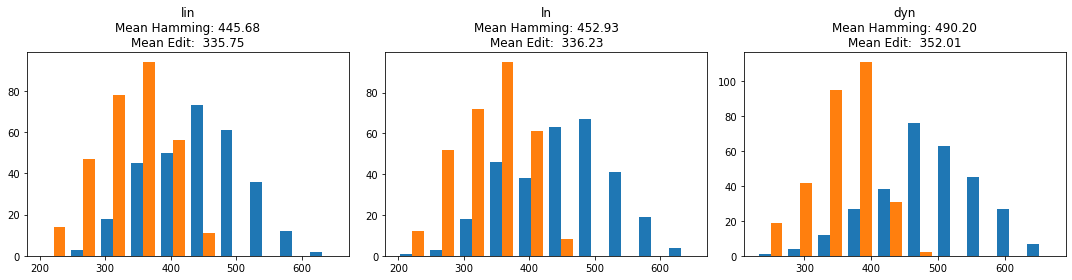

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
npair = 300

for nrl_mdl, ax in zip(NRL_MDLS, axs):
    ds_nrl_flat = ds_nrl[nrl_mdl].flatten()

    idxs_sorted_flat = np.argsort(ds_nrl_flat)
    idxs_sorted = np.transpose(np.unravel_index(idxs_sorted_flat, ds_nrl[nrl_mdl].shape))
    
    ds_hm = np.array([get_d_hm(sngs[idx_a], sngs[idx_b]) for idx_a, idx_b in idxs_sorted[:npair]])
    ds_lv = np.array([get_d_lv(sngs[idx_a], sngs[idx_b]) for idx_a, idx_b in idxs_sorted[:npair]])
    
    ax.hist(np.transpose([ds_hm, ds_lv]))
    ax.set_title(f'{nrl_mdl}\nMean Hamming: {ds_hm.mean():.2f}\nMean Edit: {ds_lv.mean(): .2f}')